In [44]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import glob
from astropy.stats import sigma_clipped_stats
from photutils import DAOStarFinder
from astropy.visualization import SqrtStretch
from astropy.visualization import simple_norm
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import CircularAperture
from photutils import CircularAnnulus
from photutils import aperture_photometry
from photutils import find_peaks
from astropy.table import Table
from astropy.nddata import NDData
from photutils.psf import extract_stars
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                                        BasicPSFPhotometry)
from photutils.psf import IntegratedGaussianPRF, DAOGroup
from photutils.background import MMMBackground, MADStdBackgroundRMS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.stats import gaussian_sigma_to_fwhm
from matplotlib.colors import LogNorm

# Data Reduction

bias frames: due to electronics, derived from a closed shutter and a minimized detecting time.
dark frames: bias + dark current. They are derived from a closed shutter with a longer detecting time.

In [45]:
#Combining the bias frames to make a master bias\
bias_list = glob.glob('Wolf1346/bias*.fits')
print(bias_list)

bias = fits.open('Wolf1346/bias.0010.fits')
sum_bias = bias[0].data - bias[0].data

for filename in bias_list:
    hdu = fits.open(filename)
    sum_bias += hdu[0].data
    
master_bias = sum_bias / 11
master_bias

['Wolf1346/bias.0015.fits', 'Wolf1346/bias.0014.fits', 'Wolf1346/bias.0013.fits', 'Wolf1346/bias.0009.fits', 'Wolf1346/bias.0008.fits', 'Wolf1346/bias.0012.fits', 'Wolf1346/bias.0011.fits', 'Wolf1346/bias.0007.fits', 'Wolf1346/bias.0006.fits', 'Wolf1346/bias.0010.fits', 'Wolf1346/bias.0016.fits']


array([[ 317.27272727,  315.90909091, 1549.45454545, ..., 1106.27272727,
         338.54545455,  338.54545455],
       [ 303.45454545,  302.        ,  333.45454545, ...,  342.        ,
         309.09090909,  309.36363636],
       [ 313.63636364,  311.63636364,  342.        , ...,  349.54545455,
         316.72727273,  316.81818182],
       ...,
       [ 318.36363636,  316.36363636,  347.63636364, ...,  350.        ,
         318.54545455,  319.27272727],
       [ 306.09090909,  306.18181818,  335.81818182, ...,  340.09090909,
         307.90909091,  308.27272727],
       [ 327.09090909,  327.18181818, 1315.63636364, ..., 1637.36363636,
         333.18181818,  333.90909091]])

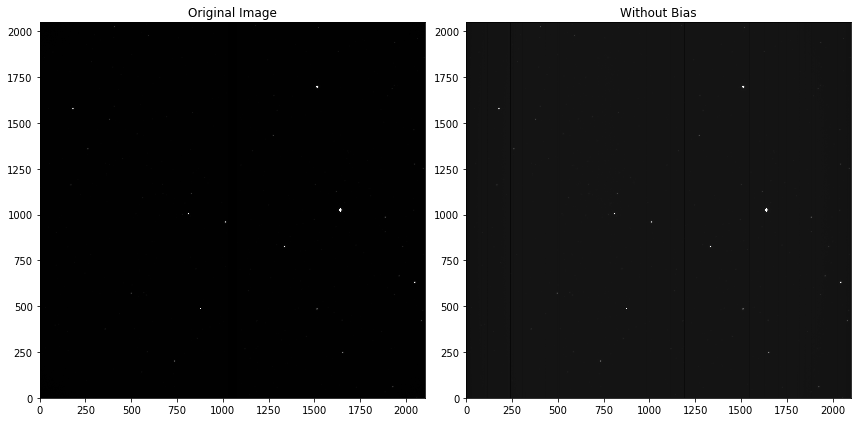

In [46]:
#Removing the bias with the master bias
image = fits.open('Wolf1346/wolf1346_.0001.fits')
image_data = image[0].data

image_NoBias = image_data - master_bias[0].data

fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].set_title("Original Image")
ax[1].set_title("Without Bias")

ax[0].imshow(image_data, origin='lower', cmap=plt.cm.gray)

ax[1].imshow(image_NoBias, origin='lower', cmap=plt.cm.gray);

In [47]:
#Averaging values of bias frames
for filename in bias_list:
    hdu = fits.open(filename)
    print(np.mean(hdu[0].data))
    
#Average value of the master bias
print("master bias mean:", np.mean(master_bias))

351.5752312547864
351.6943257292706
351.67762200923625
351.7383458262746
351.65315007774245
351.40129446984287
351.7116537095913
351.3568139518693
351.70354319927594
351.675116381611
351.4999043883874
master bias mean: 351.47656093552536


In [48]:
#Getting rid of the overscan rows
rows = []
for i, item in enumerate(image_data):
    if np.median(item) > 500:
        rows.append(i)
    else:
        print(i)
image_NoOverRows = image_data[rows]

1024
1025


In [49]:
#Getting rid of the overscan columns
columns = []
transpose = image_NoOverRows.transpose()
for i, item in enumerate(transpose):
    if np.median(item) > 500:
        columns.append(i)
    else:
        print(i)
        
image_NoOverscan = transpose[columns].transpose()

0
1
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
2100
2101


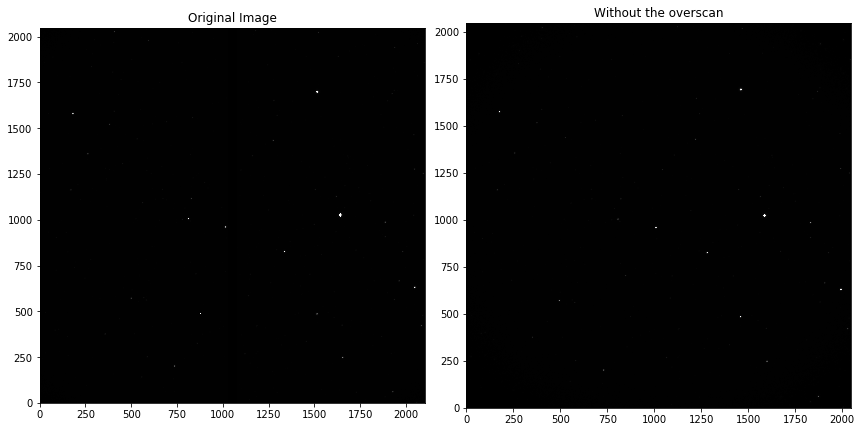

In [50]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].set_title("Original Image")
ax[1].set_title("Without the overscan")

ax[0].imshow(image_data, origin='lower', cmap=plt.cm.gray)

ax[1].imshow(image_NoOverscan, origin='lower', cmap=plt.cm.gray);

In [51]:
#For the flats
flat_list = glob.glob('Wolf1346/flat*.fits')
len(flat_list)

37

In [52]:
#Summing the flats for each filter
header = []
sum_WashM = fits.open('Wolf1346/flat.0005.fits')
sum_WashM = sum_WashM[0].data - sum_WashM[0].data #Empty the array

sum_jcRC = fits.open('Wolf1346/flat.0017.fits')
sum_jcRC = sum_jcRC[0].data - sum_jcRC[0].data #Empty the array

for _,name in enumerate(flat_list):
    files = fits.open(name)
    header.append(files[0].header)
    if files[0].header["FILTER"] == "Wash M":
        print("Wash M")
        print(files[0].header["FILENAME"])
        sum_WashM += files[0].data
    else:
        print("J-C RC")
        print(files[0].header["FILENAME"])
        sum_jcRC += files[0].data

J-C RC
flat.0031.fits
J-C RC
flat.0027.fits
Wash M
flat.0007.fits
Wash M
flat.0011.fits
Wash M
flat.0010.fits
Wash M
flat.0006.fits
J-C RC
flat.0026.fits
J-C RC
flat.0030.fits
J-C RC
flat.0040.fits
J-C RC
flat.0017.fits
J-C RC
flat.0037.fits
J-C RC
flat.0021.fits
J-C RC
flat.0020.fits
J-C RC
flat.0036.fits
Wash M
flat.0016.fits
J-C RC
flat.0041.fits
J-C RC
flat.0039.fits
Wash M
flat.0015.fits
J-C RC
flat.0023.fits
J-C RC
flat.0035.fits
J-C RC
flat.0019.fits
J-C RC
flat.0018.fits
J-C RC
flat.0034.fits
J-C RC
flat.0022.fits
Wash M
flat.0014.fits
J-C RC
flat.0038.fits
J-C RC
flat.0025.fits
J-C RC
flat.0033.fits
Wash M
flat.0009.fits
J-C RC
flat.0029.fits
Wash M
flat.0013.fits
Wash M
flat.0005.fits
Wash M
flat.0012.fits
J-C RC
flat.0028.fits
Wash M
flat.0008.fits
J-C RC
flat.0032.fits
J-C RC
flat.0024.fits


In [53]:
#Getting the averaged flats for each filter and subtract the corresponding combined flat image from the science frame
washM = sum_WashM/12
jcRC = sum_jcRC/25

print(image[0].header["FILTER"]) #The filter used for the science frame 

image_NoBiasFlat = image_NoBias - jcRC #Remove the corresponding flat image from the science frame

J-C Rc


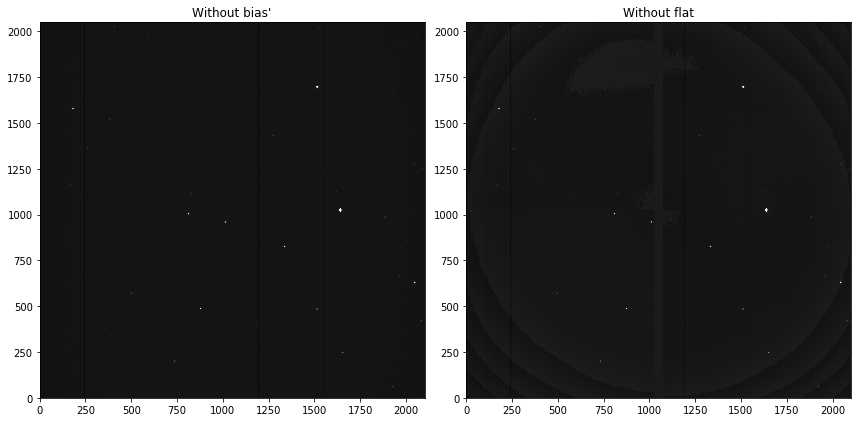

In [54]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(12,6)
fig.tight_layout()

ax[0].set_title("Without bias'")
ax[1].set_title("Without flat")

ax[0].imshow(image_NoBias, origin='lower', cmap=plt.cm.gray)

ax[1].imshow(image_NoBiasFlat, origin='lower', cmap=plt.cm.gray);

# Data Analysis

In [55]:
#Using quadRU.fits
clean_image = fits.open('Wolf1346/quadRU.fits')
clean_data = clean_image[0].data

print("size", clean_data.shape)

mean, median, std = sigma_clipped_stats(clean_data, sigma=3.0)  
print((mean, median, std)) 

size (1023, 1027)
(270.93660468351146, 267.3033979295908, 23.28821444495957)


In [56]:
#Detecting stars with DAOStarFinder
daofind = DAOStarFinder(fwhm=3.0, threshold=2.0*std) 
sources = daofind(clean_data - median)   
for col in sources.colnames:   
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)    

 id xcentroid ycentroid  sharpness  ... sky     peak       flux       mag     
--- --------- ---------- ---------- ... --- ----------- --------- ------------
  1 561.24032 0.98844182 0.26166317 ...   0   61138.279 1168.6265   -7.6691893
  2 191.31778  1.7511154 0.46223046 ...   0   136.31184 1.6650986   -0.5535999
  3 563.32306  2.5362342 0.38136097 ...   0   60631.672 671.44526   -7.0675265
  4 633.88426  5.7279147 0.59304799 ...   0   153.79991 1.7907381  -0.63258018
  5 565.16586  5.3306433 0.52517768 ...   0   60689.042 902.09738   -7.3881335
  6 111.42178  8.5959945 0.54964855 ...   0   152.80112 1.7850384  -0.62911893
  7 634.53956   5.567725  0.5691028 ...   0   104.69202  1.168313  -0.16889804
  8 52.781877  11.254343 0.65291774 ...   0   71.939431 1.2632223  -0.25369942
  9 113.29778  14.259994 0.74862649 ...   0   53.767993 1.0340948 -0.036400841
 10  471.7425  16.688638  0.3365853 ...   0   40.754575 1.0013598  -0.00147533
...       ...        ...        ... ... ...         

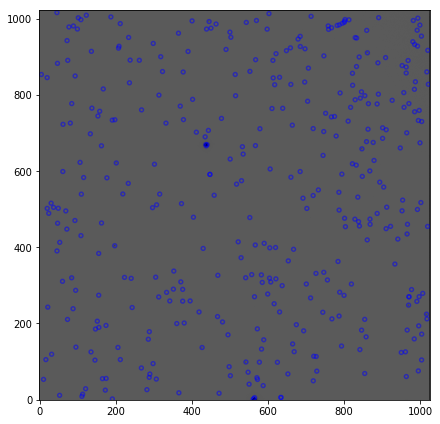

In [57]:
#Plotting the detected stars (As the stars are too small I used apertures in this case)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
fig.tight_layout()
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=5.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(clean_data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [58]:
#Selecting a smaller set and removing "bad" stars (just for the edges since it's quadRU.fits)
daofind = DAOStarFinder(fwhm=3.0, threshold=3.4*std)
sources = daofind(clean_data - median)
maskX = ((sources['xcentroid'] > 20) &
         (sources['xcentroid'] < 1003))
sources = sources[maskX]
maskY = ((sources['ycentroid'] > 20) &
         (sources['ycentroid'] < 1007))
sources = sources[maskY]
for col in sources.colnames:   
    sources[col].info.format = '%.8g'  # for consistent table output
print(sources)    

 id xcentroid ycentroid sharpness  ... sky    peak      flux       mag    
--- --------- --------- ---------- ... --- --------- --------- -----------
  7 172.86073 24.842898 0.39871687 ...   0 3608.1145 23.716032  -3.4376051
  8 587.58473 36.755588   0.451668 ...   0 1895.2595 11.123505  -2.6156042
  9 550.59566 40.523033  0.4503779 ...   0 490.22498 3.1680576  -1.2519827
 11 306.82595 53.971888 0.44509687 ...   0 370.74932  2.306395 -0.90733421
 12   288.256 58.431758 0.49137039 ...   0 416.62829 2.6947785  -1.0763077
 13 963.62761 60.620269 0.43854674 ...   0 414.05273 2.3647426 -0.93445967
 14 501.43972 62.763899 0.51369666 ...   0 456.86686 2.6057486  -1.0398313
 15 652.53091 67.410657 0.32058501 ...   0 344.05635 2.2621338 -0.88629572
 16 854.36941 68.573083 0.41824544 ...   0  615.1453 4.0167503  -1.5096871
 17 728.45267 74.786201 0.41416982 ...   0 3815.0114 23.121332  -3.4100321
...       ...       ...        ... ... ...       ...       ...         ...
201 758.41053 981.65325 0

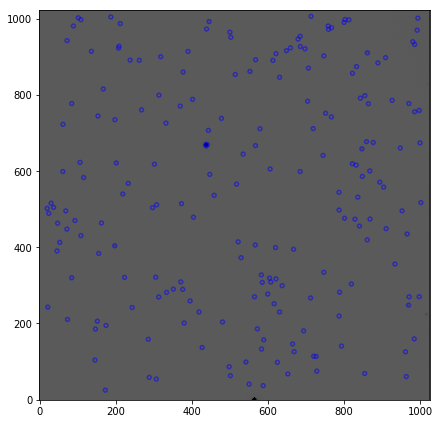

In [59]:
#Replotting the detected stars (As the stars are too small I used apertures in this case)
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
fig.tight_layout()
positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=5.)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(clean_data, cmap='Greys', origin='lower', norm=norm)
apertures.plot(color='blue', lw=1.5, alpha=0.5)

In [60]:
#For the circular aperture
apertures = CircularAperture(positions, r=4.)
phot_table = aperture_photometry(clean_data, apertures, method='subpixel',
                                                subpixels=6)
phot_table['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table)  

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 172.86072620903678 24.842898067594284    86476.571
  2  587.5847271152236 36.755588364098806    53294.876
  3  550.5956561538496  40.52303259994759    24037.076
  4  306.8259467297199  53.97188775660031    20607.753
  5  288.2560028419897  58.43175778583187    21500.419
  6  963.6276121554017  60.62026901614525    23100.202
  7  501.4397205202975  62.76389889004376    22432.467
  8  652.5309067931456  67.41065675527736    21425.162
  9   854.369411724604  68.57308312113568     26344.22
 10  728.4526718988387  74.78620052729897    95234.395
...                ...                ...          ...
191 212.10184292005087  987.8142464830703    24420.003
192  800.3053258289724   990.871351846683    17922.101
193 445.53230356034493   993.170132812014    200048.56
194 108.78209578571287  998.0802605082813    14555.956
195   812.

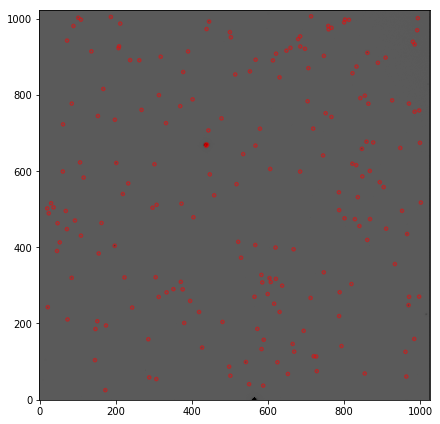

In [61]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
fig.tight_layout()
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(clean_data, cmap='Greys', origin='lower', norm = norm)
apertures.plot(color='red', lw=1.5, alpha=0.5)

 id      xcenter            ycenter       aperture_sum
           pix                pix                     
--- ------------------ ------------------ ------------
  1 172.86072620903678 24.842898067594284     27539.12
  2  587.5847271152236 36.755588364098806    27318.774
  3  550.5956561538496  40.52303259994759    25270.259
  4  306.8259467297199  53.97188775660031    23633.883
  5  288.2560028419897  58.43175778583187    24709.162
  6  963.6276121554017  60.62026901614525    25417.516
  7  501.4397205202975  62.76389889004376    24131.211
  8  652.5309067931456  67.41065675527736    24141.445
  9   854.369411724604  68.57308312113568    24608.882
 10  728.4526718988387  74.78620052729897    28627.641
...                ...                ...          ...
191 212.10184292005087  987.8142464830703    22469.586
192  800.3053258289724   990.871351846683    34882.098
193 445.53230356034493   993.170132812014    35177.793
194 108.78209578571287  998.0802605082813     49552.55
195   812.

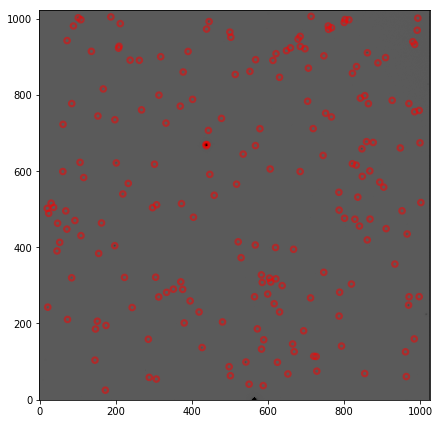

In [62]:
#For the circular annuli
fig, ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
fig.tight_layout()
annuli = CircularAnnulus(positions, r_in = 6, r_out = 8)
norm = ImageNormalize(stretch=SqrtStretch())
plt.imshow(clean_data, cmap='Greys', origin='lower', norm = norm)
annuli.plot(color='red', lw=1.5, alpha=0.5)

phot_table2 = aperture_photometry(clean_data, annuli, method='subpixel',
                                                subpixels=6)
phot_table2['aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table2)  

In [63]:
#Removing the background from the original flux
def find_sky(flux, area):
    result = flux/area;
    return result
sky = find_sky(phot_table2['aperture_sum'], annuli.area())
phot_table2['Sky'] = sky

phot_table['Without_Sky'] = phot_table['aperture_sum'] - phot_table2['Sky']*apertures.area() 
print(phot_table)

 id      xcenter            ycenter       aperture_sum Without_Sky
           pix                pix                                 
--- ------------------ ------------------ ------------ -----------
  1 172.86072620903678 24.842898067594284    86476.571   70739.931
  2  587.5847271152236 36.755588364098806    53294.876   37684.148
  3  550.5956561538496  40.52303259994759    24037.076   9596.9275
  4  306.8259467297199  53.97188775660031    20607.753   7102.6763
  5  288.2560028419897  58.43175778583187    21500.419   7380.8979
  6  963.6276121554017  60.62026901614525    23100.202    8575.907
  7  501.4397205202975  62.76389889004376    22432.467   8643.2037
  8  652.5309067931456  67.41065675527736    21425.162   7630.0507
  9   854.369411724604  68.57308312113568     26344.22   12282.002
 10  728.4526718988387  74.78620052729897    95234.395   78875.743
...                ...                ...          ...         ...
191 212.10184292005087  987.8142464830703    24420.003   11580

A few reduced fluxes appear to be negative, which is probably because some regions are crowded with stars and then the circular annuli may take some 

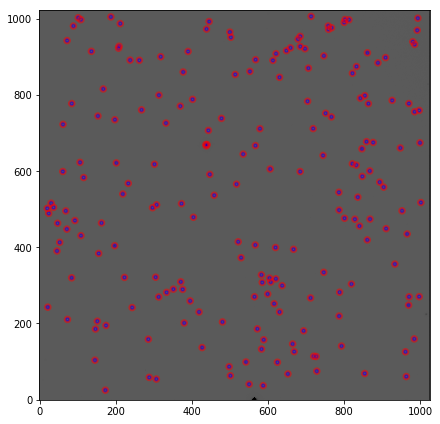

In [64]:
#Comparing the two different methods (for flux densities when we cannot compare the total fluxes
#                                     since the area of the aperatures and the area of the annuli are different.)
fig,ax = plt.subplots(1,1)
fig.set_size_inches(12,6)
fig.tight_layout()
plt.imshow(clean_data, cmap='Greys', origin='lower', norm = norm)
apertures.plot(color='blue', lw=1.5, alpha=0.7)
annuli.plot(color='red', lw=1.5, alpha=0.5)

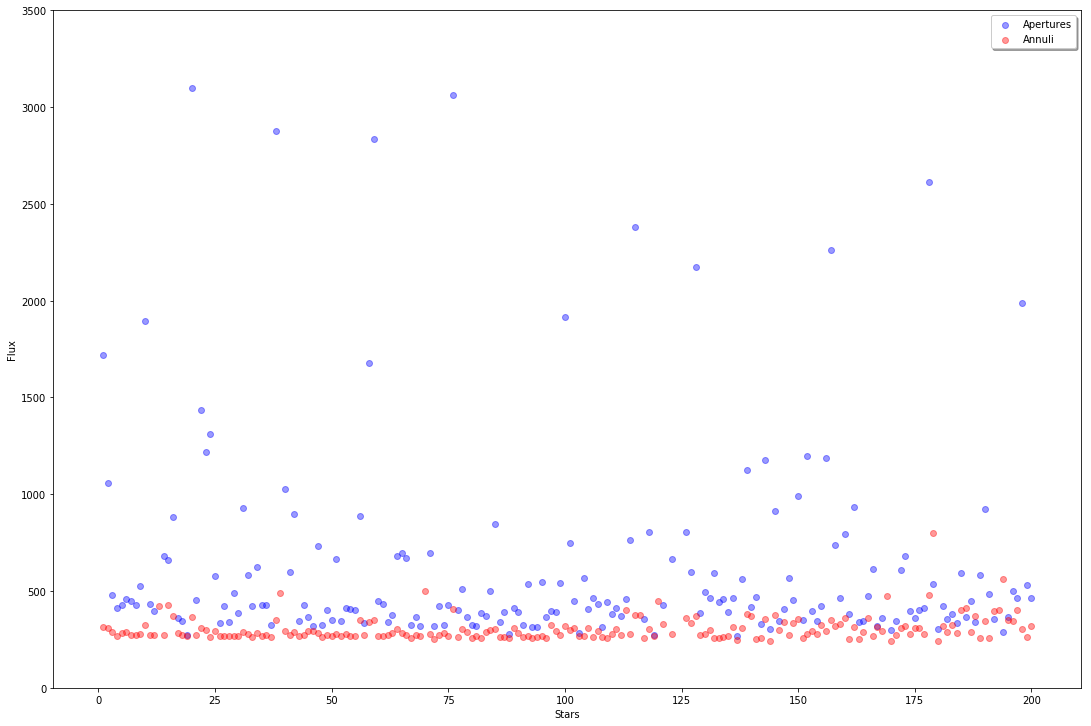

In [73]:
fig, ax = plt.subplots(1,1)                                              
fig.set_size_inches(15,10)                                                
fig.tight_layout() 

ax.set_ylim(0, 3500)
ax.set_xlabel("Stars")
ax.set_ylabel("Flux")

stars = np.arange(1,201) #creating serial numbers of stars

flux1_density = np.array(find_sky(phot_table['aperture_sum'], apertures.area()))
ax.scatter(stars, flux1_density, c = 'b', alpha = 0.4, label="Apertures")
flux2_density = np.array(phot_table2['Sky'])
ax.scatter(stars, flux2_density, c = 'r', alpha = 0.4, label="Annuli")
ax.legend(loc=0,shadow=True)

In [68]:
#Performing PSF photometry by setting up a IterativelySubtractedPSFPhotometry object
bkgrms = MADStdBackgroundRMS()
std = bkgrms(clean_data)

#To use the same set of sources, the same finder should be used
daofind = DAOStarFinder(fwhm=3.0, threshold=3.4*std)

#Gouping overlapping sources into a single model
daogroup = DAOGroup(50)
mmm_bkg = MMMBackground()
fitter = LevMarLSQFitter()

#Creating PRFs and using the same set of sources
psf_model = IntegratedGaussianPRF(sigma=3)
psf_model.x_0.fixed = True
psf_model.y_0.fixed = True
pos = Table(names=['x_0', 'y_0'], data=[sources['xcentroid'], sources['ycentroid']])
                                 

#PSF fitting
photometry = BasicPSFPhotometry(group_maker=daogroup,
                                                    bkg_estimator=mmm_bkg,
                                                    psf_model=psf_model,
                                                    fitter=LevMarLSQFitter(),
                                                    fitshape=(511,513))
result_tab = photometry(image=clean_data, init_guesses=pos)
result_tab['id', 'flux_fit']

id,flux_fit
int64,float64
1,121369.64363363002
2,67413.11143297816
3,18563.4519645005
4,12552.25177463825
5,14402.90571842958
6,17275.661657871326
7,15809.053922147408
11,14741.920503134015
13,342729.6400650279


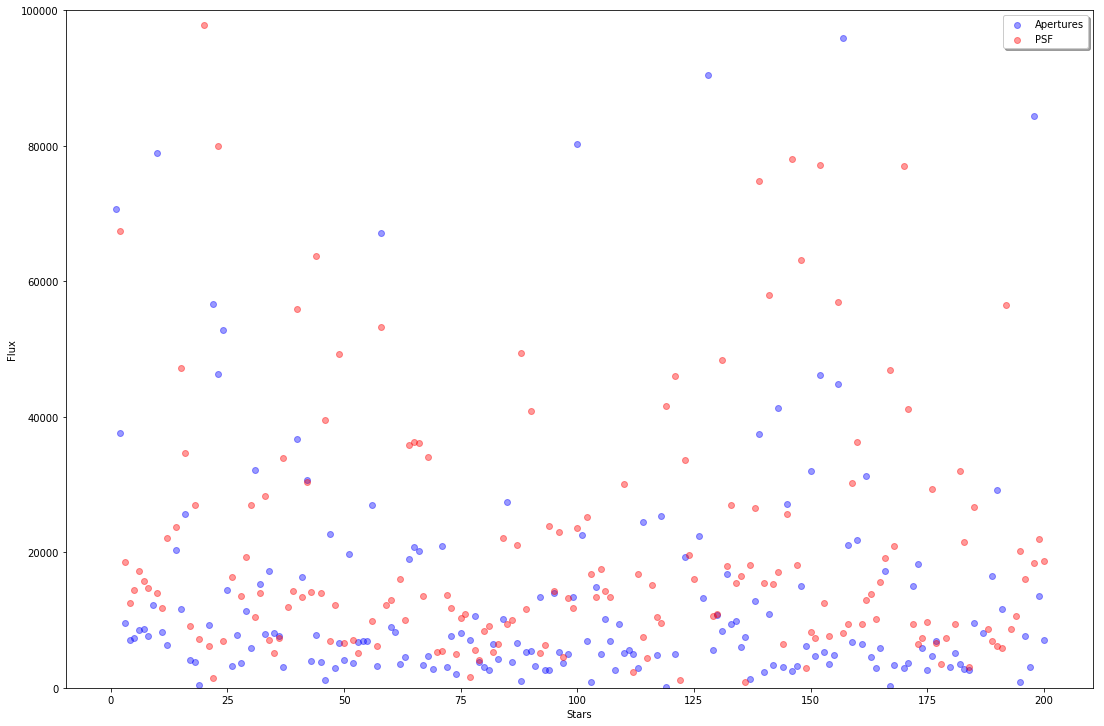

In [72]:
#Comparing the PSF fitting to the aperture photometry
fig, ax = plt.subplots(1,1)                                              
fig.set_size_inches(15,10)                                                
fig.tight_layout() 

ax.set_ylim(0, 100000)
ax.set_xlabel("Stars")
ax.set_ylabel("Flux")

flux1_density = np.array(phot_table['Without_Sky'])
ax.scatter(stars, flux1_density, c = 'b', alpha = 0.4, label="Apertures")
flux2_density = np.array(result_tab['flux_fit'])
ax.scatter(stars, flux2_density, c = 'r', alpha = 0.4, label="PSF")
ax.legend(loc=0,shadow=True)

** For Step 13, since for the analysis part I used the quadRU.fits which is a single image, then the data I was using merely corresponded to one filter.